# Trabalho Final

Importando as bibliotecas que serão usadas

In [1]:
# Util
import operator
import math
import random
import numpy as np
from numpy import linspace, sin, pi, int16
import matplotlib.pyplot as plt
%matplotlib inline

# Genetic Programming
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import librosa
import librosa.display
from IPython.display import Audio

import warnings; warnings.simplefilter('ignore')

Carregando o som desejado

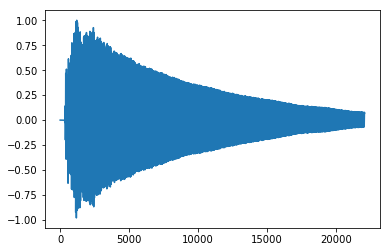

In [2]:
f0 = 440.0
#target, sr = librosa.load('SOUNDS/au_sample.wav')
#target, sr = librosa.load('SOUNDS/flute.wav')
target, sr = librosa.load('SOUNDS/harp.wav')
#target, sr = librosa.load('SOUNDS/string.wav')
target = librosa.util.normalize(target[:sr]) # normalizando etruncando para 1 segundo
duration = 1.0
plt.plot(target)
Audio(target,rate=sr)

In [3]:
# FUNCOES OPERADORES
def note(freq, amp=1.0):
    t = linspace(0,1.0,1.0*22050)
    data = sin(2.0*pi*freq*t)*amp
    return data

def fm(c_amp,c_freq, note_mod):
    t = linspace(0,1.0,1.0*22050)
    data = c_amp * sin(2.0*pi *(c_freq*t + note_mod))
    return data


In [4]:
def evaluate(individual):
    func = toolbox.compile(expr=individual)
    candidate = librosa.util.normalize(func(f0))
    
    candidate_mag = librosa.util.normalize(np.abs(librosa.stft(candidate)), axis=1)
    candidate_pha = librosa.util.normalize(np.angle(librosa.stft(candidate)), axis=1)
    
    target_mag = librosa.util.normalize(np.abs(librosa.stft(target)), axis=1)
    target_pha = librosa.util.normalize(np.angle(librosa.stft(target)), axis=1)
    
    mag_error = np.mean((candidate_mag - target_mag)**2)
    pha_error = np.mean((candidate_pha - target_pha)**2)
    
    return mag_error*0.7 + pha_error*0.3,

In [5]:
def evaluate_max(individual):
    func = toolbox.compile(expr=individual)
    candidate = librosa.util.normalize(func(f0))
    
    candidate_mag = np.abs(librosa.stft(candidate))
    candidate_pha = np.angle(librosa.stft(candidate))
    
    target_mag = np.abs(librosa.stft(target))
    target_pha = np.angle(librosa.stft(target))
    
    mag_error = np.max((candidate_mag - target_mag)**2)
    pha_error = np.max((candidate_pha - target_pha)**2)
    
    return (mag_error*0.7 + pha_error*0.3),

In [6]:
# PROGRAMAÇÂO GENETICA
pset = gp.PrimitiveSetTyped("MAIN", [float], np.ndarray, "F")

# OPERATORS
pset.addPrimitive(note, [float, float], np.ndarray)
pset.addPrimitive(operator.add,[np.ndarray,np.ndarray],np.ndarray)
pset.addPrimitive(operator.sub,[np.ndarray,np.ndarray],np.ndarray)
pset.addPrimitive(operator.mul,[np.ndarray,np.ndarray],np.ndarray)
pset.addPrimitive(fm, [float,float,np.ndarray], np.ndarray)
pset.addPrimitive(operator.add,[float,float],float)
# pset.addPrimitive(gen_cos, [float,float], list)

# TERMINALS
# if not scoop.IS_ORIGIN:
#    pset.addEphemeralConstant("rand100", lambda: random.random() * 100, float)
pset.addEphemeralConstant("rand100", lambda: random.random() * 100, float)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1), float)
pset.addTerminal(note(0), np.ndarray, 'zero')
pset.addTerminal(note(f0), np.ndarray, 'fundamental')
#pset.addTerminal(note(2*f0), np.ndarray, 'harm1')
#pset.addTerminal(note(3*f0), np.ndarray, 'harm2')
#pset.addTerminal(note(4*f0), np.ndarray, 'harm3')
pset.addTerminal(f0, float)
#pset.addTerminal(2*f0, float)
#pset.addTerminal(3*f0, float)
#pset.addTerminal(4*f0, float)

# CONFIG
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
# toolbox.register("map", futures.map)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", evaluate_max)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))

In [7]:
def main():
    random.seed(10)
    pop = toolbox.population(n=20000)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    algorithms.eaSimple(pop, toolbox, 0.75, 0.2, 100, stats, halloffame=hof)

    return pop, stats, hof

In [8]:
pop, stats, hof = main()

gen	nevals	avg   	std   	min    	max   
0  	20000 	159185	131370	25429.8	733372
1  	16101 	123970	85611 	23308.9	733178
2  	16081 	108813	81940.3	21925.4	733172
3  	15969 	89906.8	69532.1	21662.4	731125
4  	16051 	75687.7	54753.2	21925.4	724989
5  	15950 	69876.8	51799.2	20864.5	724989
6  	15937 	65364.8	48551.6	18373.5	724989
7  	15969 	61159.7	47960.3	10740.3	724989
8  	16017 	58188.6	47114.2	16785  	724989
9  	16224 	54642.2	42675  	10740.3	724989
10 	15964 	53167.9	43297.5	10740.3	724989
11 	16010 	51873.3	44768  	10740.3	731249
12 	16020 	50479.6	42099.2	10740.3	731575
13 	16071 	49463.8	43317.9	10740.3	724989
14 	16014 	48383.1	41263  	10740.3	724989
15 	16032 	47624.9	45499.6	10740.3	731215
16 	16043 	46777.1	43702.6	10740.3	726883
17 	15981 	46807  	45940.8	10526.8	724989
18 	15914 	45299.7	42860.7	10526.8	724989
19 	15978 	45211.1	43851.5	10526.8	724989
20 	16064 	44429.2	43354.6	10526.8	728167
21 	16073 	43430.9	42426.3	10526.8	731215
22 	16138 	42759.6	43014.2	10040.3	732018

In [9]:
str(hof[0])

'sub(sub(add(fm(-1, add(440.0, add(1, 0)), fm(-1, 1.5979618099021708, sub(mul(note(1, -1), note(add(440.0, add(-1, 0)), 1)), sub(fundamental, fundamental)))), mul(fundamental, mul(sub(zero, note(add(440.0, -1), 1)), mul(sub(mul(fundamental, mul(zero, fundamental)), sub(zero, fundamental)), note(-1, -1))))), mul(fundamental, fm(1.5979618099021708, 1, note(F0, 0)))), fundamental)'

In [10]:
func = toolbox.compile(hof[0])
candidate = librosa.util.normalize(func(f0))
Audio(candidate,rate=sr)

In [11]:
S.output.write_wav('SOUNDS/gen_harp3.wav',candidate,sr)

In [12]:
def print_signals(target,candidate):
    plt.figure(1,figsize=(15, 9))
    plt.subplot(221)
    plt.plot(target)
    
    plt.subplot(222)
    plt.plot(candidate)
    
    plt.subplot(223)
    D_target = librosa.amplitude_to_db(librosa.stft(target), ref=np.max)
    librosa.display.specshow(D_target, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('TARGET')
    
    plt.subplot(224)
    D_candidate = librosa.amplitude_to_db(librosa.stft(candidate), ref=np.max)
    librosa.display.specshow(D_candidate, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('CANDIDATE')

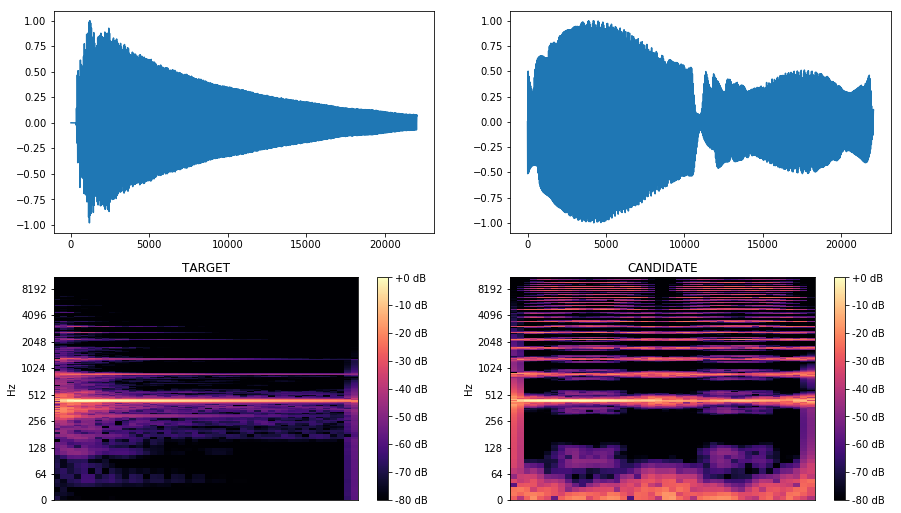

In [13]:
print_signals(target,candidate)